In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import os

Funcition turns all .jpg files into bitmap format:

In [11]:
def cutThirdDimension(bitmap):
    if bitmap.ndim == 3:
        return bitmap[..., 0]
    else:
        return bitmap

In [12]:
def scaleBitmap(bitmap):
    return bitmap/255.0

In [13]:
def turnJpgIntoBitmap(directory):  
    bitmap_files = []
    jpg_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith('.jpg')]
    for file in jpg_files:
        img = Image.open(file)
        bitmap = np.array(img)
        bitmap_files.append(scaleBitmap(cutThirdDimension(bitmap)))
    return bitmap_files

In [14]:
def turnSingleJpgIntoBitmap(single_file):
    directory = r"Tomograf-images"
    jpg_file = os.path.join(directory, single_file)
    if single_file.lower().endswith('.jpg'):
        img = Image.open(jpg_file)
        bitmap = np.array(img)
        return scaleBitmap(cutThirdDimension(bitmap))
    else:
        print('Wrong file format')
        exit()
    

In [30]:
def bresenhamAlgorithm(x1, y1, x2, y2):
    points = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    # Direction of the algorithm
    xi = 1 if x1 < x2 else -1
    yi = 1 if y1 < y2 else -1

    # First pixel
    points.append((x,y))

    if dx > dy:
        # Algorithm operates on the leading axis OX
        
        d = 2*dy - dx
        while x != x2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += y1
                d += 2*(dy-dx)
            else:
                # Move horizzontally
                d += 2*dy
                x += xi
            points.append((x,y))
    else:
        # Algorithm operates on the leading axis OY

        d = 2*dx - dy
        while y != y2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += x1
                y += yi
                d += 2*(dx-dy)
            else:
                # Move vertically
                d += 2*dx
                y += yi
            points.append((x,y))
    return points

In [15]:
def RadonTransform(bitmap):
    pass

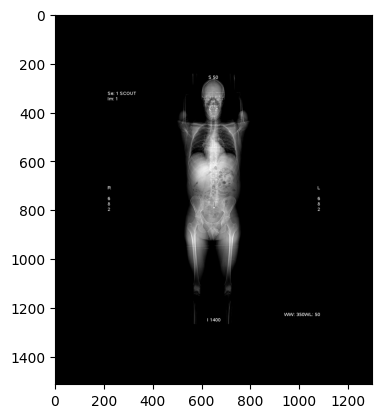

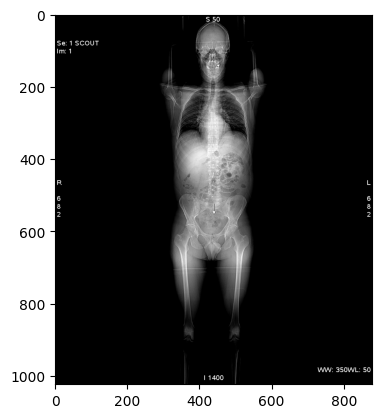

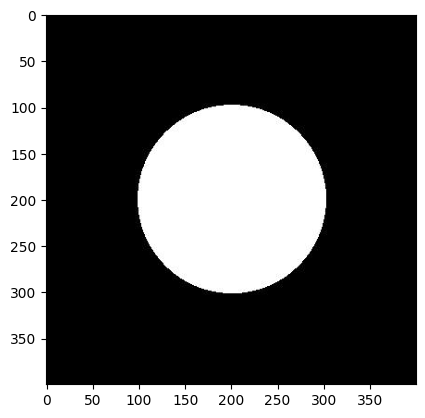

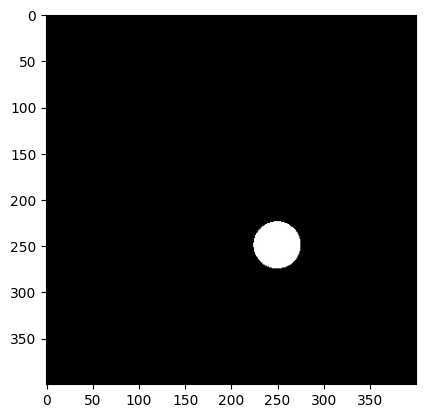

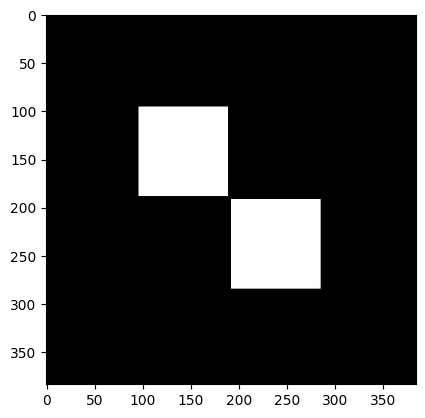

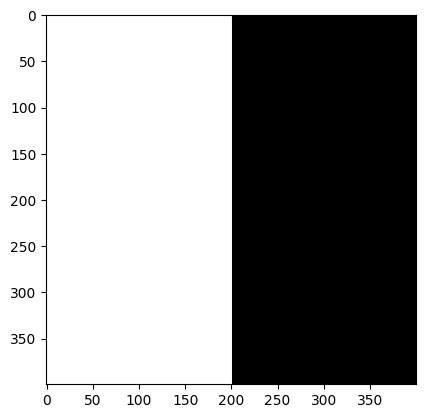

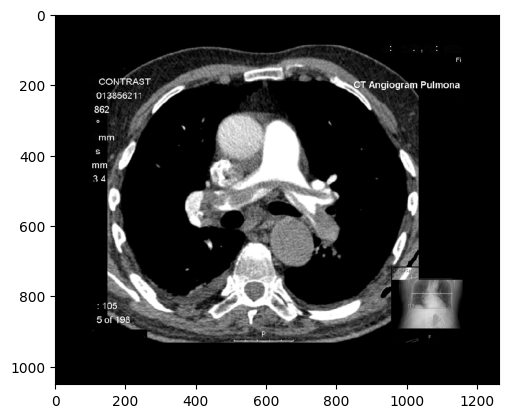

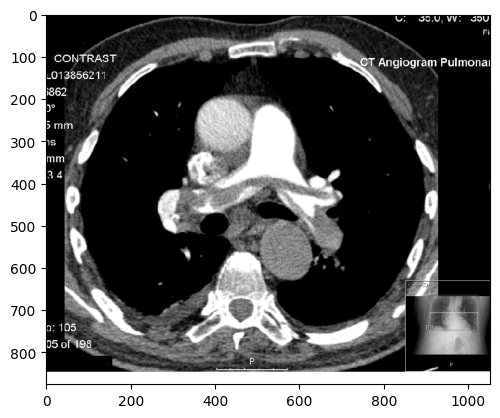

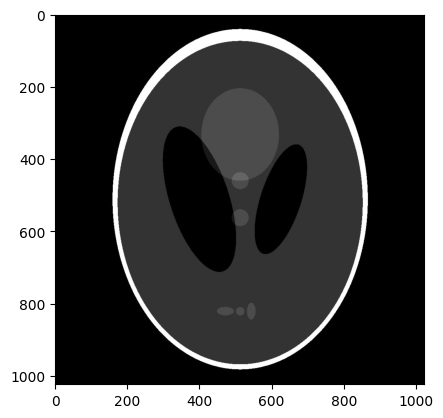

In [25]:
if __name__ == '__main__':
    #For multiple files turning into bitmaps
    bitmap_files = turnJpgIntoBitmap(r"Tomograf-images")
    for file in bitmap_files:
        plt.imshow(file, cmap='gray')
        plt.show()

    #Single file into bitmap
    # bitmap = turnSingleJpgIntoBitmap('Shepp_logan.jpg')

    

    